In [1]:
import torch

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [4]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [5]:
print(test_data)

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [6]:
print(train_data.data.size())

torch.Size([60000, 28, 28])


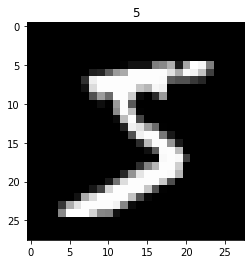

In [7]:
import matplotlib.pyplot as plt
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

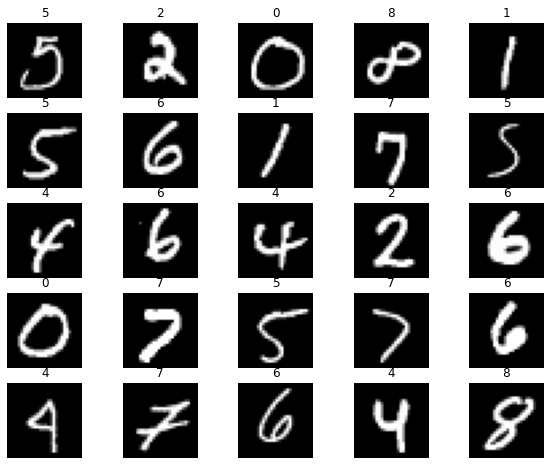

In [8]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [9]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f5200106be0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f5200106bb0>}

In [10]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

In [11]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [12]:
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [13]:
import math
from torch.optim import Optimizer

class ADAMOptimizer(Optimizer):
    """
    implements ADAM Algorithm, as a preceding step.
    """
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.99), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(ADAMOptimizer, self).__init__(params, defaults)
        
    def step(self):
        """
        Performs a single optimization step.
        """
        loss = None
        for group in self.param_groups:
            #print(group.keys())
            #print (self.param_groups[0]['params'][0].size()), First param (W) size: torch.Size([10, 784])
            #print (self.param_groups[0]['params'][1].size()), Second param(b) size: torch.Size([10])
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Momentum (Exponential MA of gradients)
                    state['exp_avg'] = torch.zeros_like(p.data)
                    #print(p.data.size())
                    # RMS Prop componenet. (Exponential MA of squared gradients). Denominator.
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']

                b1, b2 = group['betas']
                state['step'] += 1
                
                # L2 penalty. Gotta add to Gradient as well.
                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Momentum
                exp_avg = torch.mul(exp_avg, b1) + (1 - b1)*grad
                # RMS
                exp_avg_sq = torch.mul(exp_avg_sq, b2) + (1-b2)*(grad*grad)
                
                denom = exp_avg_sq.sqrt() + group['eps']

                bias_correction1 = 1 / (1 - b1 ** state['step'])
                bias_correction2 = 1 / (1 - b2 ** state['step'])
                
                adapted_learning_rate = group['lr'] * bias_correction1 / math.sqrt(bias_correction2)

                p.data = p.data - adapted_learning_rate * exp_avg / denom 
                
                if state['step']  % 10000 ==0:
                    print ("group:", group)
                    print("p: ",p)
                    print("p.data: ", p.data) # W = p.data
                
        return loss

In [16]:
from torch import optim
optimizer = ADAMOptimizer(cnn.parameters(), lr = 0.01)   
optimizer

ADAMOptimizer (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

In [17]:
from torch.autograd import Variable
num_epochs = 30
history = []
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            b_y = Variable(labels)
            loss = loss_func(test_output, b_y)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
        print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
        print('Test Loss: {:.4f}', loss.item())
    
    return accuracy, loss.item()


def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            pred_y = torch.max(output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Acc: {:.4f} Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, accuracy, loss.item()))
                pass
        
        history.append([(accuracy, loss.item()), test()])
    pass
train(num_epochs, cnn, loaders)

Epoch [1/30], Step [100/600], Acc: 0.9200 Loss: 0.2266
Epoch [1/30], Step [200/600], Acc: 0.9700 Loss: 0.1237
Epoch [1/30], Step [300/600], Acc: 0.9800 Loss: 0.1635
Epoch [1/30], Step [400/600], Acc: 0.9600 Loss: 0.1664
Epoch [1/30], Step [500/600], Acc: 0.9200 Loss: 0.0992
Epoch [1/30], Step [600/600], Acc: 0.9400 Loss: 0.1553
Test Accuracy of the model on the 10000 test images: 0.98
Test Loss: {:.4f} 0.0512511171400547
Epoch [2/30], Step [100/600], Acc: 0.9500 Loss: 0.0971
Epoch [2/30], Step [200/600], Acc: 0.9200 Loss: 0.6379
Epoch [2/30], Step [300/600], Acc: 0.9300 Loss: 0.2885
Epoch [2/30], Step [400/600], Acc: 0.9800 Loss: 0.0881
Epoch [2/30], Step [500/600], Acc: 0.9600 Loss: 0.6130
Epoch [2/30], Step [600/600], Acc: 0.9800 Loss: 0.0394
Test Accuracy of the model on the 10000 test images: 1.00
Test Loss: {:.4f} 0.00023371019051410258
Epoch [3/30], Step [100/600], Acc: 0.9500 Loss: 0.2540
Epoch [3/30], Step [200/600], Acc: 0.9500 Loss: 0.3485
Epoch [3/30], Step [300/600], Acc: 0

Epoch [17/30], Step [500/600], Acc: 0.9600 Loss: 0.4247
Epoch [17/30], Step [600/600], Acc: 0.9900 Loss: 0.0990
Test Accuracy of the model on the 10000 test images: 1.00
Test Loss: {:.4f} 0.0
Epoch [18/30], Step [100/600], Acc: 0.9800 Loss: 0.7643
Epoch [18/30], Step [200/600], Acc: 0.9700 Loss: 0.4344
Epoch [18/30], Step [300/600], Acc: 0.9500 Loss: 1.2524
Epoch [18/30], Step [400/600], Acc: 0.9900 Loss: 0.9781
Epoch [18/30], Step [500/600], Acc: 0.9100 Loss: 1.1249
Epoch [18/30], Step [600/600], Acc: 0.9900 Loss: 0.2399
Test Accuracy of the model on the 10000 test images: 0.98
Test Loss: {:.4f} 1.3600866794586182
Epoch [19/30], Step [100/600], Acc: 0.9400 Loss: 2.5171
Epoch [19/30], Step [200/600], Acc: 0.9600 Loss: 0.6840
Epoch [19/30], Step [300/600], Acc: 0.9800 Loss: 0.4200
Epoch [19/30], Step [400/600], Acc: 0.9500 Loss: 1.5232
Epoch [19/30], Step [500/600], Acc: 0.9800 Loss: 0.3669
Epoch [19/30], Step [600/600], Acc: 0.9600 Loss: 0.4542
Test Accuracy of the model on the 10000 t

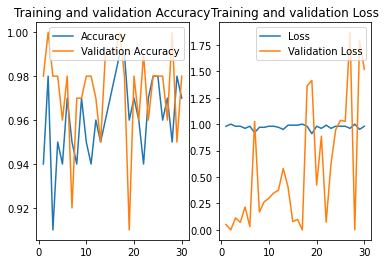

In [18]:
x = range(1, num_epochs+1)
acc = [i[0][0] for i in history]
val_acc = [i[1][0] for i in history]
loss = [i[1][0] for i in history]
val_loss = [i[1][1] for i in history]
plt.subplot(1, 2, 1)
plt.plot(x, acc, label="Accuracy")
plt.plot(x, val_acc, label="Validation Accuracy")
plt.legend(loc='upper right')
plt.title("Training and validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(x, loss, label="Loss")
plt.plot(x, val_loss, label="Validation Loss")
plt.legend(loc='upper right')
plt.title("Training and validation Loss")

plt.show()